In [19]:
%load_ext autoreload
%autoreload 2

from torch_ssl.torch_ssl import *
import pickle
import numpy as np
import xgboost as xgb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# load and devide datasets
RATIO = 0.9 # train-test ratio
with open('../data/P19_xgboost.pkl', 'rb') as f:
    dataset = pickle.load(f)
segments = dataset['data']
metadata = dataset['meta']
max_seq_len = metadata['max_seq_len']
ds_size = metadata['size']
num_sensors = metadata['num_sensors']
print(f'dataset size = {ds_size}')
print(f'max seq len in dataset = {max_seq_len}')
print(f'num sensors = {num_sensors}')
x_tr = []
x_ev = []
y_tr = []
y_ev = []
for i, segment in enumerate(segments):
    obs = segment['obs']
    label = segment['label']
    seq_len = obs.shape[0]
    # obs_padded = np.pad(obs, ((0, max_seq_len-seq_len), (0, 0)), mode='constant', constant_values=0)
    obs_padded = np.pad(obs, ((max_seq_len-seq_len, 0), (0, 0)), mode='constant', constant_values=0)
    if i + 1 <= int(RATIO * ds_size):
        x_tr.append(obs_padded)
        y_tr.append(label)
    else:
        x_ev.append(obs_padded)
        y_ev.append(label)
# make arrays
x_tr = np.expand_dims(x_tr, axis=1)  # Axis 1 is after the first dimension
print(f"initial train feature shape = {x_tr.shape}")
x_ev = np.expand_dims(x_ev, axis=1)  # Axis 1 is after the first dimension
print(f"initial eval feature shape = {x_ev.shape}")
y_tr = np.array(y_tr)
print(f"train label shape = {y_tr.shape}")
y_ev = np.array(y_ev)
print(f"eval label shape = {y_ev.shape}")


dataset size = 40336
max seq len in dataset = 336
num sensors = 7
initial train feature shape = (36302, 1, 336, 7)
initial eval feature shape = (4034, 1, 336, 7)
train label shape = (36302,)
eval label shape = (4034,)


In [21]:
# classification on original data, no processing at all

# fit the downstream task head

flat_x_tr = x_tr.reshape(x_tr.shape[0], -1)

# >>> logistic regression >>>
# classifier = LogisticRegression(max_iter=2000)
# classifier.fit(flat_x_tr, y_tr)
# <<< logistic regression <<<

# >>> xgboost classifier >>>
classifier = xgb.XGBClassifier(
    n_estimators=100,    # Number of gradient boosted trees. Equivalent to number of boosting rounds.
    max_depth=3,         # Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
    learning_rate=0.1,   # Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features.
    eval_metric='logloss' # Evaluation metric for validation data during training
)
classifier.fit(flat_x_tr, y_tr)
# <<< xgboost classifier <<<

# evaluate model
flat_x_ev = x_ev.reshape(x_ev.shape[0], -1)
y_probs = classifier.predict_proba(flat_x_ev)[:, 1] # probabilities for the positive class
print(y_probs)
auroc = roc_auc_score(y_ev, y_probs)
print(f"AUROC: {auroc:.4f}")

[0.1008506  0.01199676 0.02290171 ... 0.01266105 0.04477429 0.00903396]
AUROC: 0.9151


In [22]:
# define and fit the successive subspace learning model

# >>> first attempt subspace score = 84.1%>>>
# layer1 = torchSaab(kernel_size=(4,1), stride=(4,1), channelwise=False)
# layer2 = torchSaab(kernel_size=(4,1), stride=(4,1), channelwise=True)
# layer3 = torchSaab(kernel_size=(4,2), stride=(4,2), channelwise=True)
# layer4 = torchSaab(kernel_size=(4,2), stride=(4,2), channelwise=True)
# <<< first attempt <<<

# >>> second attempt subspace score = 85.3%>>>
# layer1 = torchSaab(kernel_size=(4,7), stride=(4,1), channelwise=False)
# layer2 = torchSaab(kernel_size=(4,1), stride=(4,1), channelwise=True)
# layer3 = torchSaab(kernel_size=(4,1), stride=(4,1), channelwise=True)
# layer4 = torchSaab(kernel_size=(4,1), stride=(4,1), channelwise=True)
# <<< second attempt <<<

# >>> third attempt subspace score = ??.?%>>>
layer1 = torchSaab(kernel_size=(3,7), stride=(3,1), channelwise=False)
layer2 = torchSaab(kernel_size=(4,1), stride=(4,1), channelwise=True)
layer3 = torchSaab(kernel_size=(4,1), stride=(4,1), channelwise=True)
layer4 = torchSaab(kernel_size=(7,1), stride=(7,1), channelwise=True)
# <<< third attempt <<<

ssl_model = sslModel([
    layer1,
    layer2,
    layer3,
    layer4,
    ])

# fit the model

ssl_model.fit(x_tr);

learned parameters for layer 0, output size was torch.Size([36302, 21, 112, 1])
learned parameters for layer 1, output size was torch.Size([36302, 84, 28, 1])
learned parameters for layer 2, output size was torch.Size([36302, 336, 7, 1])
learned parameters for layer 3, output size was torch.Size([36302, 2352, 1, 1])


In [23]:
# ssl dimensionality reduction for training features

subspace_x_tr = ssl_model(x_tr)
# trucate ac
# subspace_x_tr = subspace_x_tr[:,:4]
subspace_x_tr = subspace_x_tr.reshape(subspace_x_tr.shape[0], -1)
# ensemble
# subspace_x_tr = np.concatenate([x_tr.reshape(x_tr.shape[0], -1), subspace_x_tr,], axis=1)
print(f'features size = {subspace_x_tr.shape}')

features size = (36302, 2352)


(36302, 3020) (36302,)


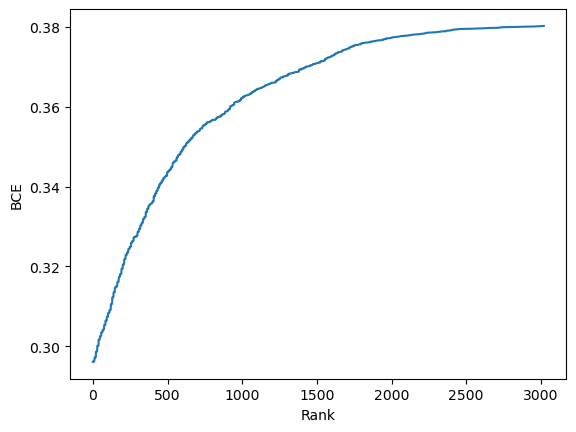

In [6]:
# define and fit the feature selection model

from feature_test.utils import *
from matplotlib import pyplot as plt

## Synthetic binary classification datasets: 1000 samples, 100 features
# X = np.random.randn(1000, 100)
# y = np.zeros(1000)
# pos_idx = np.arange(1000)
# np.random.shuffle(pos_idx)
# y[pos_idx[:500]] = 1

### train DFT
dft_model = FeatureTest(loss='bce')
print(subspace_x_tr.shape, y_tr.shape)
dft_model.fit(subspace_x_tr, y_tr, n_bins=32)

plt.figure()
plt.plot(np.arange(subspace_x_tr.shape[-1]), np.array(list(dft_model.dim_loss.values())))
plt.xlabel('Rank')
plt.ylabel('BCE')
plt.show()

In [24]:
# select top significant features
N_SELECTED = 1024

# >>> do select >>>
# selected_x_tr = dft_model.transform(subspace_x_tr, n_selected=N_SELECTED)
# print(selected_x_tr.shape)
# <<< do select <<<

# >>> bypass >>>
selected_x_tr = subspace_x_tr
# <<< bypass <<<

In [25]:
# fit the downstream task head

import xgboost as xgb

# >>> logistic regression >>>
classifier = LogisticRegression(max_iter=3000)
classifier.fit(selected_x_tr, y_tr)
# <<< logistic regression <<<

# >>> xgboost classifier >>>
# classifier = xgb.XGBClassifier(
#     n_estimators=100,    # Number of gradient boosted trees. Equivalent to number of boosting rounds.
#     max_depth=3,         # Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
#     learning_rate=0.1,   # Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features.
#     eval_metric='logloss' # Evaluation metric for validation data during training
# )
# classifier.fit(selected_x_tr, y_tr)
# <<< xgboost classifier <<<

/Users/d9sus4/miniconda3/envs/playground/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=2000)

In [26]:
# evaluate model

subspace_x_ev = ssl_model(x_ev)
# trucate ac
# subspace_x_ev = subspace_x_ev[:,:4]
subspace_x_ev = subspace_x_ev.reshape(subspace_x_ev.shape[0] ,-1)
# ensemble
# subspace_x_ev = np.concatenate([x_ev.reshape(x_ev.shape[0], -1), subspace_x_ev,], axis=1)
# selected_x_ev = dft_model.transform(subspace_x_ev, n_selected=N_SELECTED)
y_probs = classifier.predict_proba(subspace_x_ev)[:, 1] # probabilities for the positive class
auroc = roc_auc_score(y_ev, y_probs)
print(f"AUROC: {auroc:.4f}")

AUROC: 0.8654
